In [147]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import matplotlib.cm as cm
import matplotlib.patches as patches
import math
import time
import json
import requests
import hide_code
import notebook
import re
import seaborn as sns; sns.set(style="ticks", color_codes=True)
from sklearn import cross_validation
from sklearn.neighbors import KNeighborsRegressor as KNNR
from sklearn.neighbors import KNeighborsClassifier as KNNC
from sklearn.ensemble import RandomForestRegressor as RandomForestR
from sklearn.ensemble import RandomForestClassifier as RandomForestC
from sklearn.tree import DecisionTreeRegressor as DecisionTreeR
from sklearn.tree import DecisionTreeClassifier as DecisionTreeC
from sklearn.ensemble import GradientBoostingClassifier as GradientBoosting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
%matplotlib inline
#Things to try: Logistic Regression, Random Forest, Gradient Boosting
    

In [148]:
Train = pd.read_csv('cs-training.csv')
Test = pd.read_csv('cs-test.csv')
type(Test)
Test.info()
train = pd.read_csv('cs-training.csv')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101503 entries, 0 to 101502
Data columns (total 12 columns):
Unnamed: 0                              101503 non-null int64
SeriousDlqin2yrs                        0 non-null float64
RevolvingUtilizationOfUnsecuredLines    101503 non-null float64
age                                     101503 non-null int64
NumberOfTime30-59DaysPastDueNotWorse    101503 non-null int64
DebtRatio                               101503 non-null float64
MonthlyIncome                           81400 non-null float64
NumberOfOpenCreditLinesAndLoans         101503 non-null int64
NumberOfTimes90DaysLate                 101503 non-null int64
NumberRealEstateLoansOrLines            101503 non-null int64
NumberOfTime60-89DaysPastDueNotWorse    101503 non-null int64
NumberOfDependents                      98877 non-null float64
dtypes: float64(5), int64(7)
memory usage: 9.3 MB


In [149]:
def plot_roc(name, probs):
    fpr, tpr, thresholds = roc_curve(testdata['SeriousDlqin2yrs'], probs)
    roc_auc = auc(fpr, tpr)
    pl.clf()
    pl.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    pl.plot([0, 1], [0, 1], 'k--')
    pl.xlim([0.0, 1.05])
    pl.ylim([0.0, 1.05])
    pl.xlabel('False Positive Rate')
    pl.ylabel('True Positive Rate')
    pl.title(name)
    pl.legend(loc="lower right")
    pl.show()

In [150]:
train.describe(include='all').round(2)
# Get rid of extra index-like variables (Unamed: 0)
del train[train.columns[0]]
train.describe(include='all').round(2)

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,150000.00,150000.00,150000.00,150000.00,150000.00,120269.00,150000.00,150000.00,150000.00,150000.00,146076.00
mean,0.07,6.05,52.30,0.42,353.01,6670.22,8.45,0.27,1.02,0.24,0.76
std,0.25,249.76,14.77,4.19,2037.82,14384.67,5.15,4.17,1.13,4.16,1.12
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.18,3400.00,5.00,0.00,0.00,0.00,0.00
50%,0.00,0.15,52.00,0.00,0.37,5400.00,8.00,0.00,1.00,0.00,0.00
75%,0.00,0.56,63.00,0.00,0.87,8249.00,11.00,0.00,2.00,0.00,1.00
max,1.00,50708.00,109.00,98.00,329664.00,3008750.00,58.00,98.00,54.00,98.00,20.00


In [151]:
# Determine which features require preprocessing.
def list_features_wmissing(dataset):
    '''
    Returns all features that have missing values:
        - a list of just those features.'''
    print('Summary Statistics on Full Data set:\n{}'.format(dataset.describe(include='all').round(2)))
    has_null = pd.DataFrame({'Total_missings' : dataset.isnull().sum()})
    has_null[(has_null.Total_missings >0)].index.tolist()
    print('\n\n{} Features containing missing values: {}\n'
          .format(len(has_null[(has_null.Total_missings >0)].index.tolist()),
           has_null[(has_null.Total_missings >0)].index.tolist()))
    print(has_null.ix[2:,:])
    return has_null[(has_null.Total_missings >0)].index.tolist()

feature_wnull = list_features_wmissing(train)

Summary Statistics on Full Data set:
       SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines        age  \
count         150000.00                             150000.00  150000.00   
mean               0.07                                  6.05      52.30   
std                0.25                                249.76      14.77   
min                0.00                                  0.00       0.00   
25%                0.00                                  0.03      41.00   
50%                0.00                                  0.15      52.00   
75%                0.00                                  0.56      63.00   
max                1.00                              50708.00     109.00   

       NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
count                             150000.00  150000.00      120269.00   
mean                                   0.42     353.01        6670.22   
std                                    4.19    2037.82     

In [152]:
# Feed this list as input to a general function that 
# trains a model of missings imputations for each
def get_correlates_dict(dataset, feature_wnull, not_same=True, output_variable=None):
    correlated_predictionary = {}
    for target in feature_wnull:
        if target not in output_variable:
            try:
                corrMatrix = pd.DataFrame({'Correlation': dataset.corr().ix[:,target].sort_values()})
                corrAbsMatrix = corrMatrix.copy()
                corrAbsMatrix['Absolute'] = corrAbsMatrix.Correlation.apply(lambda x : abs(x)) 
                corrAbsMatrix.sort_values('Absolute', inplace=True)
                print('\nCorrelation Matrix with Respect to {}:\n'.format(target),
                      corrAbsMatrix)
                iteration = -3
                best_correlates = corrAbsMatrix.index.tolist()\
                                  [iteration : len(corrAbsMatrix.index.tolist())]
                if not_same:
                    # Remove any similarly named correlates that 
                    # likely to be transformations of the same target variable.
                    exclude_by_name = []
                    for c in corrAbsMatrix.index.tolist():
                        similar = re.search(target, c)
                        if similar:
                            exclude_by_name.append(c)
                    best_correlates = [choice for choice in best_correlates 
                                       if choice not in exclude_by_name]
                    if output_variable:
                        exclude_by_name.append(output_variable)
                    iteration = -3
                    while len(best_correlates) < 3:
                        iteration -= 1
                        best_correlates = corrAbsMatrix.index.tolist()\
                                          [iteration : len(corrAbsMatrix.index.tolist())]
                        best_correlates = [choice for choice in best_correlates 
                                           if choice not in exclude_by_name]  
                print('\nTOP 3 Correlates with {}: (EXCLUDES {})\n{}\n\n{}'.
                      format(target, exclude_by_name, corrAbsMatrix.tail(abs(iteration)), best_correlates))
                correlated_predictionary[target] = best_correlates
            except:
                print('get_correlates_dict ERROR: {}'.format(target))
    return correlated_predictionary

correlated_features = get_correlates_dict(train, feature_wnull, output_variable='SeriousDlqin2yrs')


Correlation Matrix with Respect to MonthlyIncome:
                                       Correlation  Absolute
RevolvingUtilizationOfUnsecuredLines     0.007124  0.007124
NumberOfTime30-59DaysPastDueNotWorse    -0.010217  0.010217
NumberOfTime60-89DaysPastDueNotWorse    -0.011116  0.011116
NumberOfTimes90DaysLate                 -0.012743  0.012743
SeriousDlqin2yrs                        -0.019746  0.019746
DebtRatio                               -0.028712  0.028712
age                                      0.037717  0.037717
NumberOfDependents                       0.062647  0.062647
NumberOfOpenCreditLinesAndLoans          0.091455  0.091455
NumberRealEstateLoansOrLines             0.124959  0.124959
MonthlyIncome                            1.000000  1.000000

TOP 3 Correlates with MonthlyIncome: (EXCLUDES ['MonthlyIncome', 'SeriousDlqin2yrs'])
                                 Correlation  Absolute
NumberOfDependents                  0.062647  0.062647
NumberOfOpenCreditLinesAndLoans

In [153]:
# Feed this dictionary into a function that 
# trains a model of missings imputations
def get_encoded_features_list(dataset, discrete_threshold=None, excepting=None, only=None):
    '''Returns a list of discrete variables that
       have numerical values signifying missing.
       (i.e. 96=DK, 98=REFUSED)'''
    contain_missing = []
    print('\nINSPECT DISCRETE FEATURES FOR ENCODED MISSISINGS:\n')
    if not only:
        only = dataset.columns.tolist()
    only = [feature for feature in only if feature not in excepting]
    for col in only:
        if discrete_threshold:
            if len(dataset[col].unique()) < discrete_threshold:
                print('{} unique values:\n{}'.format(col, dataset[col].unique()))
                contain_missing += [col]
        else:
            contain_missing += [col]
            print('{} unique values:\n{}'.format(col, dataset[col].unique()))
    print('\nCheck for coded missings on these features: \n{}'.format(contain_missing))
    return contain_missing


def decode_extended_to_nan(dataset, contain_missing, to_replace=None, values=None):
    '''Inputs: Dataframe and list of features to encode.
       Returns a dataframe with specified encoded missings
       replaced to NAN.'''
    if (len(to_replace) == len(values)) & (isinstance(to_replace, list)):
        dataset[contain_missing] = dataset[contain_missing].replace(to_replace, values)
        new_missings = pd.DataFrame({'Total_missing' : 
                                    dataset.isnull().sum().round(2)})
        print('\nEncode obs with NAN in any of the extended missings columns: \n{}\
              \nAfter Encoding Extended Missings\n{},\n\nDrop obs with extended missings'.
              format(contain_missing, new_missings))
        return dataset, new_missings
    else:
        raise ValueError("Provide symmetrical number lists to 'to_replace' and 'values'.")
        
        
def drop_obs_w_anynan(dataset, features_list):
    '''Inputs: Dataframe and list of features to encode.
       Returns a dataset removed any obs missing
       on the specified by the features_list.'''
    excludes = [feature for feature in dataset.columns.tolist() if feature not in features_list]
    if excludes:
        print('\nDropping all row-wise missing values, EXCEPT for features:\n{}'
             .format(excludes))
    else:
        print('\nDropping all row-wise missing values for features:\n{}'
              .format(features_list))
    dataset.dropna(axis='index', how='any', inplace=True, subset=[features_list])
    print('\nAfter Dropping Extended Missings\n{}\n'
          .format(pd.DataFrame(
                 {'Total_missings' : dataset.isnull().sum()})))
    return dataset


def decode_and_drop_missings(raw_train, decodings_dict, except_threshold=None, encode_except=None, outcome_variable=None):
    '''Inputs:
        - Dataframe 
        - Decoding variables to values dictionary
        - Optional discrete_threshold (i.e. 1000 unique values)
       Returns '''
    encoded_features = get_encoded_features_list(raw_train, 
                                                 except_threshold, 
                                                 excepting=encode_except)
        
    for i in range(len(decodings_dict.keys())):
        if not decodings_dict[i]['on']:
            decodings_dict[i]['on'] = encoded_features
        else:
            encoded_features.extend(decodings_dict[i]['on'])
        raw_train, imputation_candidates = \
        decode_extended_to_nan(raw_train, decodings_dict[i]['on'], 
                               to_replace = decodings_dict[i]['to_replace'], 
                               values = decodings_dict[i]['with_replace']) 
        
    # Derive binary missing indicator variables
    dropped_train = raw_train.copy()
    derived_train = raw_train.copy()
    inspect_missing_list = []
    for feature in imputation_candidates[imputation_candidates.Total_missing > 0].index:
        if feature not in outcome_variable:
            inspect_missing_list += [feature]
            is_missing_var = feature + '_missing'
            derived_train[is_missing_var] = derived_train[feature].isnull().map({True : 1, False : 0})

    # Drop all missings 
    train_missing = dropped_train.copy()

    if outcome_variable:
        dropping_columns = [c for c in derived_train.index.tolist() if c not in outcome_variable]
        derived_train.dropna(how='any', axis=1, subset=[dropping_columns])
    else:
        derived_train.dropna(how='any', axis=1)
    dropped_train =  drop_obs_w_anynan(dropped_train, encoded_features).copy()
    return dropped_train, derived_train, train_missing, inspect_missing_list 

In [154]:
decodings_dict = {0 :{'on': None, 'to_replace' : [96, 98], 
                  'with_replace' : [np.nan, np.nan]},
                  1:{'on': ['age'],
                  'to_replace' : [0], 
                  'with_replace' : [np.nan]}}

train_alldropped, derived_train, train_missing, imputation_candidates = \
decode_and_drop_missings(train, decodings_dict, except_threshold=None, encode_except=['age','Unnamed: 0', 'SeriousDlqin2yrs'], outcome_variable=['SeriousDlqin2yrs'])


INSPECT DISCRETE FEATURES FOR ENCODED MISSISINGS:

RevolvingUtilizationOfUnsecuredLines unique values:
[ 0.76612661  0.95715102  0.65818014 ...,  0.29974515  0.24604392
  0.85028295]
NumberOfTime30-59DaysPastDueNotWorse unique values:
[ 2  0  1  3  4  5  7 10  6 98 12  8  9 96 13 11]
DebtRatio unique values:
[ 0.80298213  0.1218762   0.08511338 ...,  0.40429286  0.71656222
  0.24990808]
MonthlyIncome unique values:
[  9120.   2600.   3042. ...,  15648.    521.   7647.]
NumberOfOpenCreditLinesAndLoans unique values:
[13  4  2  5  7  3  8  9  6 10 14 22 17  1 15 31 12 21 11 19 18 26 20 23  0
 16 27 29 28 24 25 32 46 33 30 34 37 38 36 35 54 43 45 49 57 48 40 58 51 52
 39 41 56 42 47 50 44 53]
NumberOfTimes90DaysLate unique values:
[ 0  1  3  2  5  4 98 10  9  6  7  8 15 96 11 13 14 17 12]
NumberRealEstateLoansOrLines unique values:
[ 6  0  1  3  4  2  5  8  7  9 17 15 10 12 11 16 26 14 54 21 18 13 23 29 25
 19 20 32]
NumberOfTime60-89DaysPastDueNotWorse unique values:
[ 0  1  2  5  3 98 

In [155]:
derived_train.columns, imputation_candidates

(Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
        'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
        'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
        'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
        'NumberOfDependents', 'age_missing',
        'NumberOfTime30-59DaysPastDueNotWorse_missing', 'DebtRatio_missing',
        'MonthlyIncome_missing', 'NumberOfTimes90DaysLate_missing',
        'NumberOfTime60-89DaysPastDueNotWorse_missing',
        'NumberOfDependents_missing'],
       dtype='object'),
 ['age',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'DebtRatio',
  'MonthlyIncome',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse',
  'NumberOfDependents'])

In [156]:
print('\nSummarized Data After Removing Cases with Missing Values:\n')
train_alldropped.describe(include='all').round(2)


Summarized Data After Removing Cases with Missing Values:



,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00,120115.00
mean,0.07,5.91,51.31,0.26,26.63,6675.57,8.77,0.09,1.06,0.07,0.85
std,0.25,257.21,14.42,0.72,424.72,14392.78,5.17,0.49,1.15,0.34,1.15
min,0.00,0.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.03,41.00,0.00,0.14,3400.00,5.00,0.00,0.00,0.00,0.00
50%,0.00,0.18,51.00,0.00,0.30,5400.00,8.00,0.00,1.00,0.00,0.00
75%,0.00,0.58,61.00,0.00,0.48,8250.00,11.00,0.00,2.00,0.00,2.00
max,1.00,50708.00,103.00,13.00,61106.50,3008750.00,58.00,17.00,54.00,11.00,20.00


In [157]:
# Transform Data

def gen_transform_data(dataset, transform_dict, transformations=None):
    '''Inputs: 
        - Dataset
        - dictionary of features to transform with
            respective transformation function.'''
    if not transformations:            
        transformations = {'log': 'np.log'}
    for feature in transform_dict.keys():
        fx = transform_dict[feature]
        plus = 0
        if fx in transformations:
            new_feature = feature + '_' + fx
            print('\nTransforming {} by way of {} = {}'
                  .format(feature, fx, new_feature))
            if fx == 'log':
                plus = 1
            dataset[new_feature] = dataset[feature].apply(lambda x : eval(transformations[fx])(x + plus))
        else:
            raise ValueError("Provide valid transformation function. {} is invalid.".format(fx))
    return dataset

transform_features_dict = {'RevolvingUtilizationOfUnsecuredLines' : 'log', 
                           'MonthlyIncome' : 'log'}

train_transformed = gen_transform_data(train_alldropped, transform_features_dict)
train_derived_transformed = gen_transform_data(derived_train, transform_features_dict)
train_missing_transformed = gen_transform_data(train_missing, transform_features_dict)


Transforming RevolvingUtilizationOfUnsecuredLines by way of log = RevolvingUtilizationOfUnsecuredLines_log

Transforming MonthlyIncome by way of log = MonthlyIncome_log

Transforming RevolvingUtilizationOfUnsecuredLines by way of log = RevolvingUtilizationOfUnsecuredLines_log

Transforming MonthlyIncome by way of log = MonthlyIncome_log

Transforming RevolvingUtilizationOfUnsecuredLines by way of log = RevolvingUtilizationOfUnsecuredLines_log

Transforming MonthlyIncome by way of log = MonthlyIncome_log


In [158]:
train_transformed.columns

Index(['SeriousDlqin2yrs', 'RevolvingUtilizationOfUnsecuredLines', 'age',
       'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome',
       'NumberOfOpenCreditLinesAndLoans', 'NumberOfTimes90DaysLate',
       'NumberRealEstateLoansOrLines', 'NumberOfTime60-89DaysPastDueNotWorse',
       'NumberOfDependents', 'RevolvingUtilizationOfUnsecuredLines_log',
       'MonthlyIncome_log'],
      dtype='object')

In [159]:
dropped_correlates_dict = get_correlates_dict(train_transformed, train_transformed.columns.tolist(), not_same=True, output_variable='SeriousDlqin2yrs')


Correlation Matrix with Respect to RevolvingUtilizationOfUnsecuredLines:
                                           Correlation  Absolute
DebtRatio                                   -0.000244  0.000244
NumberOfTimes90DaysLate                     -0.001901  0.001901
NumberOfDependents                           0.002342  0.002342
SeriousDlqin2yrs                            -0.002351  0.002351
NumberOfTime30-59DaysPastDueNotWorse        -0.002625  0.002625
NumberOfTime60-89DaysPastDueNotWorse        -0.002963  0.002963
age                                         -0.005508  0.005508
NumberRealEstateLoansOrLines                 0.005876  0.005876
MonthlyIncome                                0.007117  0.007117
MonthlyIncome_log                            0.008980  0.008980
NumberOfOpenCreditLinesAndLoans             -0.010940  0.010940
RevolvingUtilizationOfUnsecuredLines_log     0.499713  0.499713
RevolvingUtilizationOfUnsecuredLines         1.000000  1.000000

TOP 3 Correlates with Revolv

In [160]:
# Recall imputation candidates (features with missing data before drop)
print('CONSIDER THESE IMPUTATION CANDIDATES AFTER LOOKING AT COEFFICIENTS OF FIRST APPROXIMATION:\n',  imputation_candidates)

# Recall train_derived_transformed (contains missings binaries)
train_derived_transformed.isnull().sum()

# Keep a training set version which uses the binary versions for any variables that have missings
train_derived_transformed_dropped = train_derived_transformed.copy()
for feature in imputation_candidates:
    del train_derived_transformed_dropped[feature]
    try:
        del train_derived_transformed_dropped[feature + '_log']
    except:
        print('ERROR:{}'.format(feature + '_log'))
print('\nSummarize Training Set Version that Replaces Imputation Candidates with Binary Missings Variables:\n')
train_derived_transformed_dropped
train_derived_transformed_dropped.isnull().sum()

CONSIDER THESE IMPUTATION CANDIDATES AFTER LOOKING AT COEFFICIENTS OF FIRST APPROXIMATION:
 ['age', 'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio', 'MonthlyIncome', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
ERROR:age_log
ERROR:NumberOfTime30-59DaysPastDueNotWorse_log
ERROR:DebtRatio_log
ERROR:NumberOfTimes90DaysLate_log
ERROR:NumberOfTime60-89DaysPastDueNotWorse_log
ERROR:NumberOfDependents_log

Summarize Training Set Version that Replaces Imputation Candidates with Binary Missings Variables:



SeriousDlqin2yrs                                0
RevolvingUtilizationOfUnsecuredLines            0
NumberOfOpenCreditLinesAndLoans                 0
NumberRealEstateLoansOrLines                    0
age_missing                                     0
NumberOfTime30-59DaysPastDueNotWorse_missing    0
DebtRatio_missing                               0
MonthlyIncome_missing                           0
NumberOfTimes90DaysLate_missing                 0
NumberOfTime60-89DaysPastDueNotWorse_missing    0
NumberOfDependents_missing                      0
RevolvingUtilizationOfUnsecuredLines_log        0
dtype: int64

In [161]:
ismiss_correlates_dict = get_correlates_dict(train_derived_transformed_dropped, train_derived_transformed_dropped.columns.tolist(), not_same=True, output_variable=['SeriousDlqin2yrs'])


Correlation Matrix with Respect to RevolvingUtilizationOfUnsecuredLines:
                                               Correlation  Absolute
age_missing                                     -0.000052  0.000052
DebtRatio_missing                               -0.000415  0.000415
NumberOfTime30-59DaysPastDueNotWorse_missing    -0.000857  0.000857
NumberOfTimes90DaysLate_missing                 -0.000857  0.000857
NumberOfTime60-89DaysPastDueNotWorse_missing    -0.000857  0.000857
MonthlyIncome_missing                            0.001196  0.001196
SeriousDlqin2yrs                                -0.001802  0.001802
NumberOfDependents_missing                       0.003082  0.003082
NumberRealEstateLoansOrLines                     0.006235  0.006235
NumberOfOpenCreditLinesAndLoans                 -0.011281  0.011281
RevolvingUtilizationOfUnsecuredLines_log         0.509120  0.509120
RevolvingUtilizationOfUnsecuredLines             1.000000  1.000000

TOP 3 Correlates with RevolvingUtilizati

In [162]:
# Review variables that are most correlated in both versions of the transformed data.
print("Review variable correlations for each version of the \
'NON-MISSING' transformed training data:\
\n-Casewise drop of any examples with missings:")
dropped_correlates_dict     

Review variable correlations for each version of the 'NON-MISSING' transformed training data:
-Casewise drop of any examples with missings:


{'DebtRatio': ['NumberRealEstateLoansOrLines',
  'MonthlyIncome',
  'MonthlyIncome_log'],
 'MonthlyIncome': ['NumberOfDependents',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberRealEstateLoansOrLines'],
 'MonthlyIncome_log': ['NumberRealEstateLoansOrLines',
  'MonthlyIncome',
  'DebtRatio'],
 'NumberOfDependents': ['MonthlyIncome_log',
  'NumberRealEstateLoansOrLines',
  'age'],
 'NumberOfOpenCreditLinesAndLoans': ['MonthlyIncome_log',
  'age',
  'NumberRealEstateLoansOrLines'],
 'NumberOfTime30-59DaysPastDueNotWorse': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'NumberOfTime60-89DaysPastDueNotWorse': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTimes90DaysLate',
  'NumberOfTime30-59DaysPastDueNotWorse'],
 'NumberOfTimes90DaysLate': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'NumberRealEstateLoansOrLines': ['Monthly

In [163]:
print("\n-Column wise drop of columns with missing examples, \
replaced by '_missing' binary variables:")
ismiss_correlates_dict


-Column wise drop of columns with missing examples, replaced by '_missing' binary variables:


{'DebtRatio_missing': ['NumberOfOpenCreditLinesAndLoans',
  'NumberRealEstateLoansOrLines',
  'MonthlyIncome_missing'],
 'MonthlyIncome_missing': ['NumberRealEstateLoansOrLines',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberOfDependents_missing'],
 'NumberOfDependents_missing': ['NumberRealEstateLoansOrLines',
  'NumberOfOpenCreditLinesAndLoans',
  'MonthlyIncome_missing'],
 'NumberOfOpenCreditLinesAndLoans': ['RevolvingUtilizationOfUnsecuredLines_log',
  'MonthlyIncome_missing',
  'NumberRealEstateLoansOrLines'],
 'NumberOfTime30-59DaysPastDueNotWorse_missing': ['SeriousDlqin2yrs',
  'NumberOfTimes90DaysLate_missing',
  'NumberOfTime60-89DaysPastDueNotWorse_missing'],
 'NumberOfTime60-89DaysPastDueNotWorse_missing': ['SeriousDlqin2yrs',
  'NumberOfTime30-59DaysPastDueNotWorse_missing',
  'NumberOfTimes90DaysLate_missing'],
 'NumberOfTimes90DaysLate_missing': ['SeriousDlqin2yrs',
  'NumberOfTime30-59DaysPastDueNotWorse_missing',
  'NumberOfTime60-89DaysPastDueNotWorse_missing'],
 'Num

In [164]:
train_missing_transformed
impute_correlates_dict = get_correlates_dict(train_missing_transformed, train_missing_transformed.columns.tolist(), not_same=True, output_variable='SeriousDlqin2yrs')
train_missing_transformed.isnull().sum()
impute_correlates_dict


Correlation Matrix with Respect to RevolvingUtilizationOfUnsecuredLines:
                                           Correlation  Absolute
NumberOfDependents                           0.001557  0.001557
SeriousDlqin2yrs                            -0.001802  0.001802
NumberOfTimes90DaysLate                     -0.001807  0.001807
NumberOfTime60-89DaysPastDueNotWorse        -0.002441  0.002441
NumberOfTime30-59DaysPastDueNotWorse        -0.002819  0.002819
DebtRatio                                    0.003960  0.003960
age                                         -0.005899  0.005899
NumberRealEstateLoansOrLines                 0.006235  0.006235
MonthlyIncome                                0.007124  0.007124
MonthlyIncome_log                            0.008983  0.008983
NumberOfOpenCreditLinesAndLoans             -0.011281  0.011281
RevolvingUtilizationOfUnsecuredLines_log     0.509120  0.509120
RevolvingUtilizationOfUnsecuredLines         1.000000  1.000000

TOP 3 Correlates with Revolv

{'DebtRatio': ['NumberOfOpenCreditLinesAndLoans',
  'NumberRealEstateLoansOrLines',
  'MonthlyIncome_log'],
 'MonthlyIncome': ['NumberOfDependents',
  'NumberOfOpenCreditLinesAndLoans',
  'NumberRealEstateLoansOrLines'],
 'MonthlyIncome_log': ['NumberRealEstateLoansOrLines',
  'MonthlyIncome',
  'DebtRatio'],
 'NumberOfDependents': ['MonthlyIncome_log',
  'NumberRealEstateLoansOrLines',
  'age'],
 'NumberOfOpenCreditLinesAndLoans': ['age',
  'MonthlyIncome_log',
  'NumberRealEstateLoansOrLines'],
 'NumberOfTime30-59DaysPastDueNotWorse': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTimes90DaysLate',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'NumberOfTime60-89DaysPastDueNotWorse': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTimes90DaysLate',
  'NumberOfTime30-59DaysPastDueNotWorse'],
 'NumberOfTimes90DaysLate': ['RevolvingUtilizationOfUnsecuredLines_log',
  'NumberOfTime30-59DaysPastDueNotWorse',
  'NumberOfTime60-89DaysPastDueNotWorse'],
 'NumberRealEstateLoansO

In [165]:
imputation_candidates
# impute_correlates_dict

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents']

In [166]:
train_missing_transformed.columns.tolist()

['SeriousDlqin2yrs',
 'RevolvingUtilizationOfUnsecuredLines',
 'age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'MonthlyIncome',
 'NumberOfOpenCreditLinesAndLoans',
 'NumberOfTimes90DaysLate',
 'NumberRealEstateLoansOrLines',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'NumberOfDependents',
 'RevolvingUtilizationOfUnsecuredLines_log',
 'MonthlyIncome_log']

In [195]:
# Build Model and Results Dictionaries:
# Try predicting each imputation candidate using each version.
training_version = {}
print('\nCOMPARE CORRELATES OF KEY IMPUTATION CANDIDATES OF EACH VERSION OF TRAINING SET:\n')
for feature in imputation_candidates:
    print(dropped_correlates_dict[feature])
    if feature in dropped_correlates_dict:
        if 0 in training_version:
            pass
        else:
            training_version[0] = {}
        training_version[0][feature] = dropped_correlates_dict[feature]
    if feature in ismiss_correlates_dict:
        try:
            if 1 in training_version:
                pass
            else:
                training_version[1] = {}
            print(ismiss_correlates_dict[feature])
            training_version[1] = {feature : ismiss_correlates_dict[feature]}
        except:
            print('not in data')
    if feature in impute_correlates_dict:
        try:
            if 2 in training_version:
                pass
            else:
                training_version[2] = {}
            print(impute_correlates_dict[feature])
            training_version[2] = {feature : impute_correlates_dict[feature]}
        except:
            print('not in data')

print(training_version)
    

model_builder = {'trainees': [train_transformed, train_derived_transformed_dropped],
                 'test_sizes': [.20, .20],
                 'C': { 'RandomForestC' : {'n_estimators': ['NA', 10, 100], 'min_samples_split': ['NA', 1, 5, 10], 'class_weight' : ['NA', 'balanced', 'balanced_subsample']},
                       'DecisionTreeC' : {'max_depth': ['NA', 100], 'min_samples_split':['NA', 1, 5, 10],
                                         'class_weight' : ['NA', 'balanced']},
                       'KNNC' : {'n_neighbors': [ 1, 2, 3, 5], 'weights': ['uniform', 'distance']}},
                 'R': {'RandomForestR' : {'n_estimators':['NA', 10, 100],'min_samples_split': ['NA', 1, 5, 10]}, #,
                       'DecisionTreeR' : {'max_depth': ['NA', 10, 100], 'min_samples_split':['NA', 1, 5, 10]},
                       'KNNR' : {'n_neighbors': [ 1, 2, 3, 5], 'weights': ['uniform', 'distance']}},
                 'versions':training_version
                 }


def get_mse(predicted, val_targets):
    return (((predicted - val_targets) ** 2).sum()) / len(predicted)
                     


COMPARE CORRELATES OF KEY IMPUTATION CANDIDATES OF EACH VERSION OF TRAINING SET:

['RevolvingUtilizationOfUnsecuredLines_log', 'NumberOfOpenCreditLinesAndLoans', 'NumberOfDependents']
['NumberOfOpenCreditLinesAndLoans', 'RevolvingUtilizationOfUnsecuredLines_log', 'NumberOfDependents']
['RevolvingUtilizationOfUnsecuredLines_log', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
['RevolvingUtilizationOfUnsecuredLines_log', 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse']
['NumberRealEstateLoansOrLines', 'MonthlyIncome', 'MonthlyIncome_log']
['NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines', 'MonthlyIncome_log']
['NumberOfDependents', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
['NumberOfDependents', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
['RevolvingUtilizationOfUnsecuredLines_log', 'NumberOfTime30-59DaysPastDueNotWorse', 'NumberOfTime60-89DaysPastDueNotWorse']
['RevolvingUtilizationOf

In [197]:
def split_and_run(classifier_dictionary, outcome_variable, reg_or_clf='R', testing=False,
                  cols=None, test_size=0.20, 
                  results_dataframe=None,
                  filename='output'):
    # X_train, X_val = cross_validation.train_test_split(train_transformed, test_size = 0.20)
    results_matrix = {'Model': [], 
                      'Training_set': [], 
                      'Y_outcome' : [],
                      'Test_size': [],
                      'Classifier': [],
                      'Regressor': [],
                      'Predictors': [],
                      'n_estimators': [],
                      'max_depth': [],
                      'min_samples_split': [],
                      'metric': [],
                      'metric_score': [],
                      'cross_val_metric': [],
                      'score': []
                     }
    write_to = filename + '.xlsx'
        
    # Loop through models in classifier_dictionary
    model_number = 0
    best = {'score': float(0), 'model_dict': None, 'Classifier': None, 'Regressor': None}
    if not results_dataframe:
        results_dataframe = results_matrix.copy()
    for dataset in range(len(classifier_dictionary['trainees'])):
        # Split the training data into a training set and a validation set
        if not cols:
            if outcome_variable in classifier_dictionary['versions'][dataset]:
                cols = classifier_dictionary['versions'][dataset][outcome_variable]
            else:
                print('Outcome {} not in dataset {}'.format(outcome_variable, dataset))
                continue
        for testsize in classifier_dictionary['test_sizes']:
            X_train, X_val = cross_validation.train_test_split(classifier_dictionary['trainees'][dataset].copy(),
                                                               test_size = testsize)
            
            # Build the ML Regressor/Classifier
            if reg_or_clf == 'C':
                trainer_arg = 'Classifier'
                trainer_counter_arg = 'Regressor'
            elif reg_or_clf == 'R':
                trainer_arg = 'Regressor'
                trainer_counter_arg = 'Classifier'
            for learner in classifier_dictionary[reg_or_clf]:
                model_dict = {}
                for stats_key in classifier_dictionary[reg_or_clf][learner].keys():  
                    if stats_key not in results_dataframe:
                        results_dataframe[stats_key] = []
                        for i in range(model_number - len(results_dataframe[stats_key])):
                            results_dataframe[stats_key].append(np.nan)
                    for stat_value in classifier_dictionary[reg_or_clf][learner][stats_key]: 
                        model_dict[stats_key] = stat_value
                        
                        model_number += 1

                        parameters = {}
                        for model_key in model_dict:
                            if model_key in classifier_dictionary[reg_or_clf][learner]:
                                if model_dict[model_key]!="NA":
                                    parameters[model_key] = model_dict[model_key]

                        model_dict['Model'] = model_number
                        model_dict['Y_outcome'] = outcome_variable
                        model_dict['Training_set'] = dataset
                        model_dict['Test_size'] = testsize        
                        model_dict[trainer_arg] = learner
                        model_dict[trainer_counter_arg] = np.nan
                        

                        clf = eval(learner)()
                        clf_args = clf.get_params()
                        for param in parameters:
                            clf.set_params(**{param:parameters[param]})

                        #Fit the model to the training inputs and training targets
                        model_dict['Predictors'] = cols
                        clf.fit(X_train[cols].as_matrix(), X_train[outcome_variable].as_matrix())

                        #Predict the output on the validation
                        predicted = clf.predict(X_val[cols].as_matrix())
                        

                        X_val[outcome_variable + '_predicted'] = predicted
                        mse = get_mse(predicted, X_val[outcome_variable].as_matrix())
                        if testing:
                            mse = abs(Train[outcome_variable].mean() - X_val[outcome_variable + '_predicted'].mean())
                            model_dict['metric'] = 'Train_mean - Testing_mean'
                            print('Size of Testing Set:', X_val.size, ', Size of Validation (Training) Set:',Train.size)
                            print('Sum of validation Y:',Train[outcome_variable].sum())
                            print(' Sum of predicted Y:', predicted.sum())
                        else:
                            model_dict['metric'] = 'mse'
                         
                        model_dict['metric_score'] = mse
                            
                        score = np.nan
                        
                        try:
                            score = clf.score(X_train[cols], X_train[outcome_variable], sample_weight=None)
                            model_dict['score'] = score
                            score = model_dict['score']
                        except:
                            print('Clf gave no score: {}.\nSCORE is :{}'.format(clf, score))
                        try:
                            scores = cross_val_score(clf, X_train[cols], X_train[outcome_variable])
                            model_dict['cross_val_metric'] = 'cross_val_score'
                            model_dict['score'] = scores
                            score = scores
                        except:
                            model_dict['cross_val_metric'] = 'NA'
                        model_dict['score'] = score

                        # Sweep up any new or unused results keys into the results dictionary.
                        for element in model_dict:
                            if element not in results_dataframe:
                                results_dataframe[element] = []
                                for i in range(model_number - len(results_dataframe[element])):
                                    results_dataframe[element].append(np.nan)
                                results_dataframe[element].append(model_dict[element])

                        for unused_k in results_dataframe:
                            if unused_k not in model_dict:
                                for i in range(model_number - len(results_dataframe[unused_k])):
                                    results_dataframe[unused_k].append(np.nan)
                            else:
                                results_dataframe[unused_k].append(model_dict[unused_k])
                        
                        results = pd.DataFrame.from_dict(results_dataframe)
                        results.to_excel(write_to)
                        
                        X_val[[outcome_variable + '_predicted', outcome_variable]].describe().round(2)
                        
                        if model_dict['score'] > best['score']:
                            print('\nMODEL SCORE to beat:', best['score'])
                            best['model_dict'] = None
                            best['score'] = model_dict['score']
                            best['Regressor'] = model_dict['Regressor']
                            best['Classifier'] = model_dict['Classifier']
                            print('\n\tBETTER MODEL!\n')
                            print('Model {}.'.format(model_dict['Model']))
                            for better_result in model_dict:
                                if better_result != 'Model':
                                    print(better_result, model_dict[better_result])
                            best['model_dict'] = model_dict.copy()
                            best['PARAMETERS'] = parameters.copy()
                            best['model_dict'] = model_dict.copy()
                            try:
                                importances = clf.feature_importances_
                                sorted_idx = np.argsort(importances)
                                padding = np.arange(len(cols)) + 0.5
                                plt.close('all')
                                fig, ax = plt.subplots(figsize=(10,8))
                                t = 'Model {} Imputed {} by {}:\nVariable Importances of {}'.format(model_number, outcome_variable, learner, cols)
                                doc = '{}_{}_{}_feat_importance.png'.format(filename, model_number, learner)
                                plt.barh(padding, importances[sorted_idx], align='center')
                                plt.yticks(padding, cols)
                                plt.xlabel("Relative Importance")
                                plt.title(t)
                                plt.tight_layout()
                                fig.savefig(doc)
                            except:
                                print('Clf has no feature_importances_ attribute:') 
                            
                            
                        results.to_excel(write_to)
                        del X_val[outcome_variable + '_predicted']
    print('\n\tBEST MODEL!:\n')
    for key in best:
        print(key, best[key])
    return pd.DataFrame.from_dict(results_dataframe), best

SeriousDlqin2yrs                                0
RevolvingUtilizationOfUnsecuredLines            0
age                                             1
NumberOfTime30-59DaysPastDueNotWorse          269
DebtRatio                                      48
MonthlyIncome                               29731
NumberOfOpenCreditLinesAndLoans                 0
NumberOfTimes90DaysLate                       269
NumberRealEstateLoansOrLines                    0
NumberOfTime60-89DaysPastDueNotWorse          269
NumberOfDependents                           3924
RevolvingUtilizationOfUnsecuredLines_log        0
MonthlyIncome_log                           29731
dtype: int64
SeriousDlqin2yrs                                0
RevolvingUtilizationOfUnsecuredLines            0
age                                             0
NumberOfTime30-59DaysPastDueNotWorse            0
DebtRatio                                       0
MonthlyIncome                               29731
NumberOfOpenCreditLinesAndLoans      

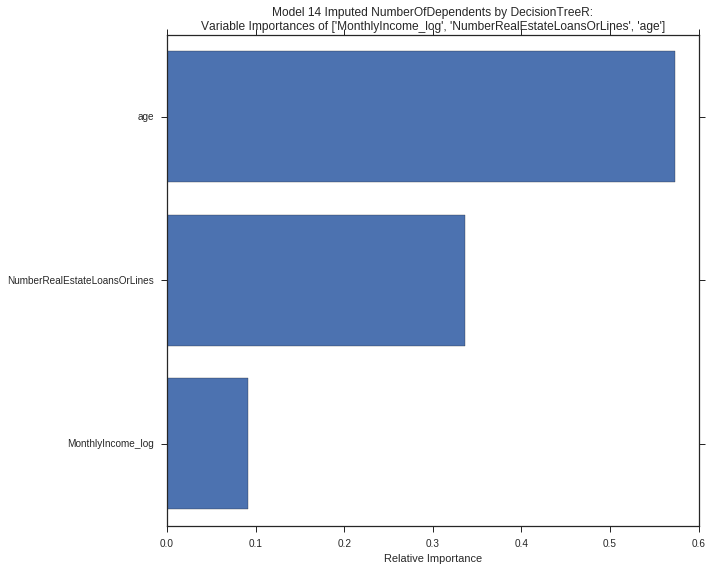

In [187]:
# Run models on ['MonthlyIncome','NumberOfDependents']
to_impute =['MonthlyIncome','NumberOfDependents']
to_avg = [c for c in train_transformed.columns.tolist() if c not in to_impute]
outcome = 'SeriousDlqin2yrs'
to_avg = [c for c in to_avg if c not in outcome]
train_impute = train_missing_transformed.copy()

IMPUTATIONS = {}
print(train_impute.isnull().sum())
train_impute.describe()

drop_after = []
for feature in to_impute:
    # Specify predictive features (determined from training set)
    if feature == 'MonthlyIncome':
        cols = ['NumberOfDependents', 'NumberOfOpenCreditLinesAndLoans', 'NumberRealEstateLoansOrLines']
    elif feature == 'NumberOfDependents':
        cols = ['MonthlyIncome_log', 'NumberRealEstateLoansOrLines', 'age'] 
    
    train_impute[feature] = train_missing_transformed[feature].copy()   
    for other_feature in to_impute:
        if other_feature != feature:
            mean_other = other_feature + '_mean'
            drop_after.append(mean_other)
            train_impute[mean_other] = train_impute[other_feature].fillna(train_impute[other_feature].mean())
            train_impute[other_feature] = train_impute[other_feature].fillna(train_impute[other_feature].mean())
    for dismiss_feature in to_avg:
        train_impute[dismiss_feature] = train_impute[dismiss_feature].fillna(train_impute[dismiss_feature].mean())
    print(train_impute.isnull().sum())
    
    # Store results of the imputation model on the test/training set.
    file = 'test_impute_' + feature
    file = 'train_impute_' + feature
    
    # Deal with missings. Update model_builder for imputing.
    model_builder['trainees'] = [train_transformed]
    results_df, best_model = split_and_run(model_builder, feature, reg_or_clf='R', filename=file)

    print('\nCONVERGED! Imputing {} with the best fit model:\n{}'.format(feature, best_model))
    
    # Compile selected classifier:
    if best_model['Regressor']:
        clf = eval(best_model['Regressor'])()
    if len(best_model['PARAMETERS'].keys()) > 0:
        for param in best_model['PARAMETERS']:
            clf.set_params(**{param:best_model['PARAMETERS'][param]})
    IMPUTATIONS[feature] = clf
    print('IMPUTATIONS\n', IMPUTATIONS)
    
    #Split data into people who reported the imputation feature versus those that didn't
    have_it = train_impute[train_impute[feature].isnull()==False].copy()
    dont_have_it = train_impute[train_impute[feature].isnull()==True].copy()

    # Impute with the best model for features with missings (Monthly Income and Number of Dependents).
    imputer = clf 
    imputer.fit(have_it[cols].as_matrix(), have_it[feature].as_matrix())
    new_imputations = imputer.predict(dont_have_it[cols].as_matrix())
    dont_have_it[feature] = new_imputations
    
    combined = have_it.append(dont_have_it)
    train_impute[feature] = combined[feature].copy()
    checklog = feature + '_log'
    if checklog in train_impute.columns.tolist():
        train_impute[checklog] = train_impute[feature].apply(lambda x: np.log(x) if x > 0 else np.log(x + 1))
    

In [ ]:
# Select and apply classifier to the outcome variable on the dataset.
# Now run imputed data through selected model 
features = ['RevolvingUtilizationOfUnsecuredLines_log',
            'age', 'NumberOfTime30-59DaysPastDueNotWorse',
            'DebtRatio','MonthlyIncome_log', 'NumberOfOpenCreditLinesAndLoans', 
            'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
            'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']

finale = train_impute.copy()
finale.drop(drop_after, inplace=True, axis=1)
print(finale.columns)
train, holdout = cross_validation.train_test_split(finale, test_size = 0.10)

# Update model_builder for training on outcome.
model_builder['trainees'] = [train.copy()]
outcome = 'SeriousDlqin2yrs'
file = 'train_impute_' + outcome

outcome_results_df, outcome_best_model = split_and_run(model_builder, outcome, reg_or_clf= 'C', cols=features, filename=file) 

# Compile selected classifier:
if outcome_best_model['Classifier']:
    clf = eval(outcome_best_model['Classifier'])()
if len(outcome_best_model['PARAMETERS'].keys()) > 0:
    for param in outcome_best_model['PARAMETERS']:
        clf.set_params(**{param:outcome_best_model['PARAMETERS'][param]})

classifier = clf
classifier.fit(train[features].as_matrix(), train[outcome].as_matrix())
probs = classifier.predict_proba(holdout[features].as_matrix())[::,1]
preds = classifier.predict(holdout[features].as_matrix())


print(classification_report(holdout[outcome], classifier.predict(holdout[features]), labels=[0, 1]))

def plot_confusion_matrix(cm, title='Confusion matrix', doc='outcome_confusion_matrix', cmap=plt.cm.Blues):
    plt.close('all')
    fig, ax = plt.subplots(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.xticks([0,1])
    plt.yticks([0,1])
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    fig.savefig(doc)


# Compute confusion matrix
cm = confusion_matrix(np.array(holdout[outcome]),np.array(preds))
print(cm)
plot_confusion_matrix(cm)

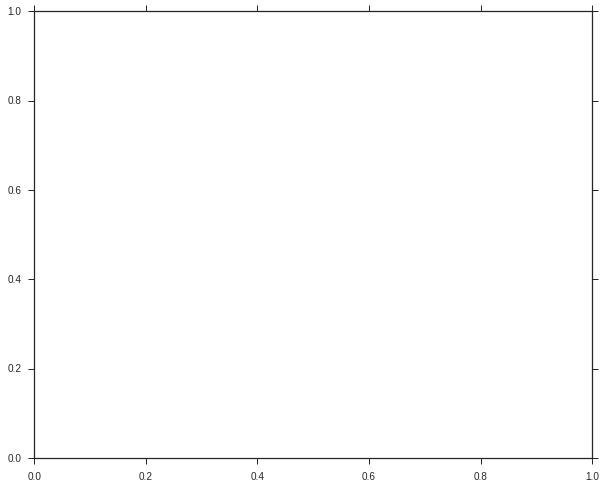

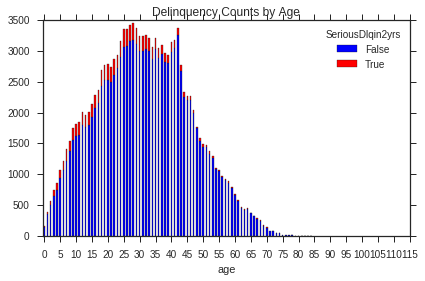

In [234]:
plt.close('all')
fig, ax = plt.subplots(figsize=(10,8))
delinquency_counts = pd.crosstab([train.age], train[outcome].astype(bool))
delinquency_counts.plot(kind = 'bar', stacked = True, color = ['blue','red'], grid = False, xticks = [])
xlabels = [20, 40, 60, 80, 100, 120]
xlabels = [a for a in range(0, 120) if a % 5 == 0]
plt.xticks(xlabels, xlabels)
plt.title('Delinquency Counts by Age')
plt.tight_layout()
fig.savefig('delinquency_counts')

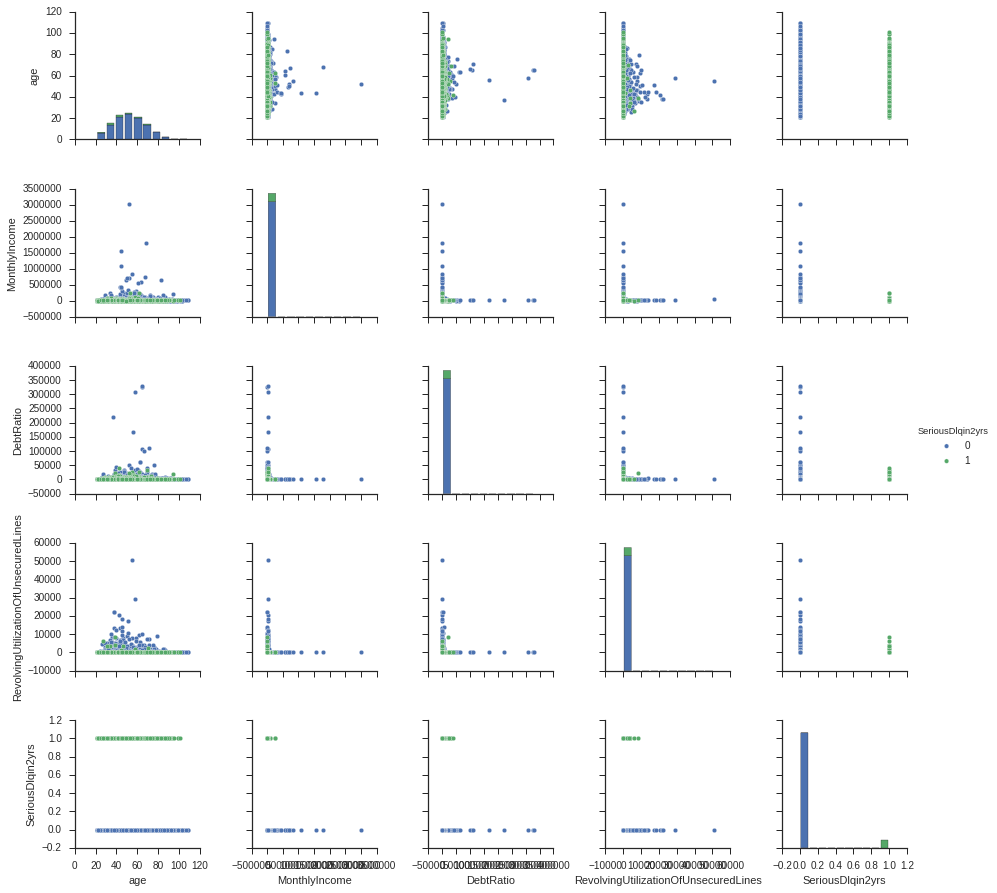

In [230]:
g = sns.pairplot(data=train[['age','MonthlyIncome','DebtRatio',
                             'RevolvingUtilizationOfUnsecuredLines',
                             'SeriousDlqin2yrs']], hue = 'SeriousDlqin2yrs')

In [ ]:
# f = sns.pairplot(data=train[features + [outcome]], hue = 'SeriousDlqin2yrs')
# f.set(xticklabels=[])